# Time logistic fitness

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

T=1.6
def logistic_model(x, a, C, K_0, K_2, K_3, K_4):
    return a * (1+C * np.exp(np.log(10)*x[0]/T)) / (C *  np.exp(np.log(10)*x[0]/T) + K_0 *  np.exp(np.log(10)*x[0]/T) + K_2 *np.exp(np.log(10)*x[2]/T) + K_3 * np.exp( np.log(10)*x[3]/T) + K_4 *  np.exp(np.log(10)*x[4]/T) + 1)
parameter_bounds = ([0, 0, 0, 0, 0, 0],
                    [np.inf, np.inf, np.inf, np.inf, np.inf , np.inf])
initial_guess = [1,  1e-8, 1e-8, 1e-8, 1e-8, 1e-8]



In [14]:
df = pd.read_csv('../data/fitness_data.csv')
print(df.shape)
df['mutations_x'] = df['mutations_x'].str.replace('[', '')
df['mutations_x'] = df['mutations_x'].str.replace(']', '')
df['mutations_x'] = df['mutations_x'].str.replace(' ', '')

df['mutations_x'] = df['mutations_x'].str.replace("'", '')
df['mutations_x'] = df['mutations_x'].str.replace("''", '')

# create list of mutations
df['mutations_x'] = df['mutations_x'].apply(lambda x: x.split(','))
# to list
df['mutations_x'] = df['mutations_x'].apply(lambda x: list(x))
# rename delta as deltaG_fold
df = df.rename(columns={'delta': 'deltaG_fold'})
# drop if log10Kd_ACE2 is 5
df = df[df['log10Kd_ACE2'] !=5.0]
df['real_f'] = df['s'].values + 1
features = ['log10Kd_ACE2', 'log10Kd_CB6',
            'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']

for feature in features:
    new_column_name = 'ln_' + feature[5:]
    # Calculate natural logarithm by multiplying log to base 10 value by ln(10)
    df[new_column_name] = df[feature] * np.log(10)

ln_features = ['ln_Kd_ACE2', 'ln_Kd_CB6',
               'ln_Kd_CoV555', 'ln_Kd_REGN10987', 'ln_Kd_S309']



(32768, 31)


In [15]:
df_existing=df[df['count']>0]
df_existing.columns

Index(['new_fitness', 'mutations_x', 'geno', 'genotype', 'deltaG_fold',
       'mutations_y', 'delta_3D', 'average_date', 'log10Kd_ACE2',
       'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309',
       's', 'binary', 'real_f', 'ln_Kd_ACE2', 'ln_Kd_CB6', 'ln_Kd_CoV555',
       'ln_Kd_REGN10987', 'ln_Kd_S309', 'pred_f', 'encoding', 'median',
       'average', 'q10', 'q25', 'q01', 'count', 'n_mutations', 'binary_epi'],
      dtype='object')

In [16]:
time_columns=['median', 'average', 'q10', 'q25', 'q01']

In [17]:
#plot average date vs pref_f 
#average date to datetime. remove if date is not available
LABEL='q01'
df_existing[LABEL]=pd.to_datetime(df_existing[LABEL],errors='coerce')
#remove if date is not available
df_existing=df_existing.dropna(subset=[LABEL])
#if Nat, remove
df_existing=df_existing.dropna(subset=[LABEL])
#sort by average date
df_existing=df_existing.sort_values(by=LABEL)
#index on average date
df_existing=df_existing.set_index(LABEL)
#drop if date after 2022--05-01
df_existing=df_existing[df_existing.index<'2022-05-01']
#check index is monotonic
df_existing.index.is_monotonic_increasing

/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_97579/393947044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_existing[LABEL]=pd.to_datetime(df_existing[LABEL],errors='coerce')


True

In [19]:
DATE='2021-5-01'
df_train=df_existing[df_existing.index<DATE]
df_train_with=df_train[df_train['mutations_x'].apply(lambda x: 'S:T478K' in x)]
df_train_without=df_train[df_train['mutations_x'].apply(lambda x: 'S:T478K' not in x)]

df_test=df_existing[df_existing.index>=DATE]
df_test_with=df_test[df_test['mutations_x'].apply(lambda x: 'S:T478K' in x)]
df_test_without=df_test[df_test['mutations_x'].apply(lambda x: 'S:T478K' not in x)]

#show sizes
print('train with',df_train_with.shape)
print('train without',df_train_without.shape)
print('test with',df_test_with.shape)
print('test without',df_test_without.shape)

train with (8, 30)
train without (34, 30)
test with (590, 30)
test without (253, 30)


In [20]:
#fit logistic model on training set
param_with,_=curve_fit(logistic_model, [df_train_with[features[0]],df_train_with[features[1]],df_train_with[features[2]],df_train_with[features[3]],df_train_with[features[4]]], df_train_with['real_f'], bounds=parameter_bounds, p0=initial_guess, maxfev=100000)
param_without,_=curve_fit(logistic_model, [df_train_without[features[0]],df_train_without[features[1]],df_train_without[features[2]],df_train_without[features[3]],df_train_without[features[4]]], df_train_without['real_f'], bounds=parameter_bounds, p0=initial_guess, maxfev=100000)

#predict on test set
df_test_with['pred_f_time']=logistic_model([df_test_with[features[0]],df_test_with[features[1]],df_test_with[features[2]],df_test_with[features[3]],df_test_with[features[4]]], *param_with)
df_test_without['pred_f_time']=logistic_model([df_test_without[features[0]],df_test_without[features[1]],df_test_without[features[2]],df_test_without[features[3]],df_test_without[features[4]]], *param_without)
df_test=pd.concat([df_test_with,df_test_without])
#order
df_test_sorted=df_test.sort_values(by=LABEL)
#predict on train set
df_train_with['pred_f_time']=logistic_model([df_train_with[features[0]],df_train_with[features[1]],df_train_with[features[2]],df_train_with[features[3]],df_train_with[features[4]]], *param_with)
df_train_without['pred_f_time']=logistic_model([df_train_without[features[0]],df_train_without[features[1]],df_train_without[features[2]],df_train_without[features[3]],df_train_without[features[4]]], *param_without)
df_train=pd.concat([df_train_with,df_train_without])
#order


/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_97579/2353086072.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_with['pred_f_time']=logistic_model([df_test_with[features[0]],df_test_with[features[1]],df_test_with[features[2]],df_test_with[features[3]],df_test_with[features[4]]], *param_with)
/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_97579/2353086072.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_without['pred_f_time']=logistic_model([df_test_without[feat

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


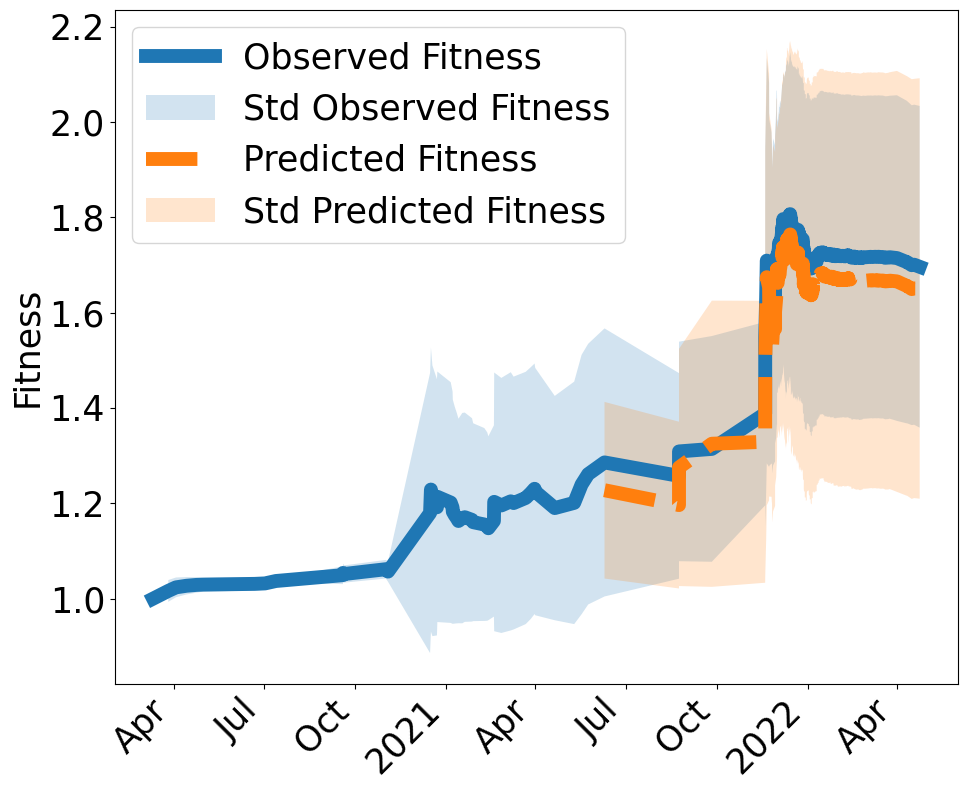

In [21]:
#plot prediction on test set. 
df_existing['rolled_real_f']=df_existing['real_f'].rolling('120D').mean()
df_existing['rolled_real_f_std']=df_existing['real_f'].rolling('120D').std()
df_test_sorted['rolled_pred_f']=df_test_sorted['pred_f_time'].rolling('120D').mean()
df_test_sorted['rolled_pred_f_std']=df_test_sorted['pred_f_time'].rolling('120D').std()

plt.figure(figsize=(10, 8))

df_existing['rolled_real_f'].plot(label='Observed Fitness', linewidth=10.0)
plt.fill_between(df_existing.index, 
                 df_existing['rolled_real_f']-df_existing['rolled_real_f_std'], 
                 df_existing['rolled_real_f']+df_existing['rolled_real_f_std'], 
                 alpha=0.2, label='Std Observed Fitness')

# Plot prediction starting from the 15th point
df_test_sorted['rolled_pred_f'].iloc[3:].plot(label='Predicted Fitness', linewidth=10.0, linestyle='--')
plt.fill_between(df_test_sorted.index[3:], 
                 df_test_sorted['rolled_pred_f'].iloc[3:]-df_test_sorted['rolled_pred_f_std'].iloc[3:], 
                 df_test_sorted['rolled_pred_f'].iloc[3:]+df_test_sorted['rolled_pred_f_std'].iloc[3:], 
                 alpha=0.2, label='Std Predicted Fitness')


plt.xlabel('', fontsize=25)
plt.ylabel('Fitness', fontsize=25)
plt.legend(loc='upper left', fontsize=25)
plt.tick_params(axis='x', rotation=45, labelsize=25)
plt.tick_params(axis='y', labelsize=25)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig('../paper/predicting_jump.png', dpi=300)
# plt.savefig('predicting_jump.eps', format='eps', dpi=1200)
# plt.savefig('predicting_jump.pdf', format='pdf', dpi=1200)
plt.show()



## T478 outlier

R^2 Score: 0.7639971564104173


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


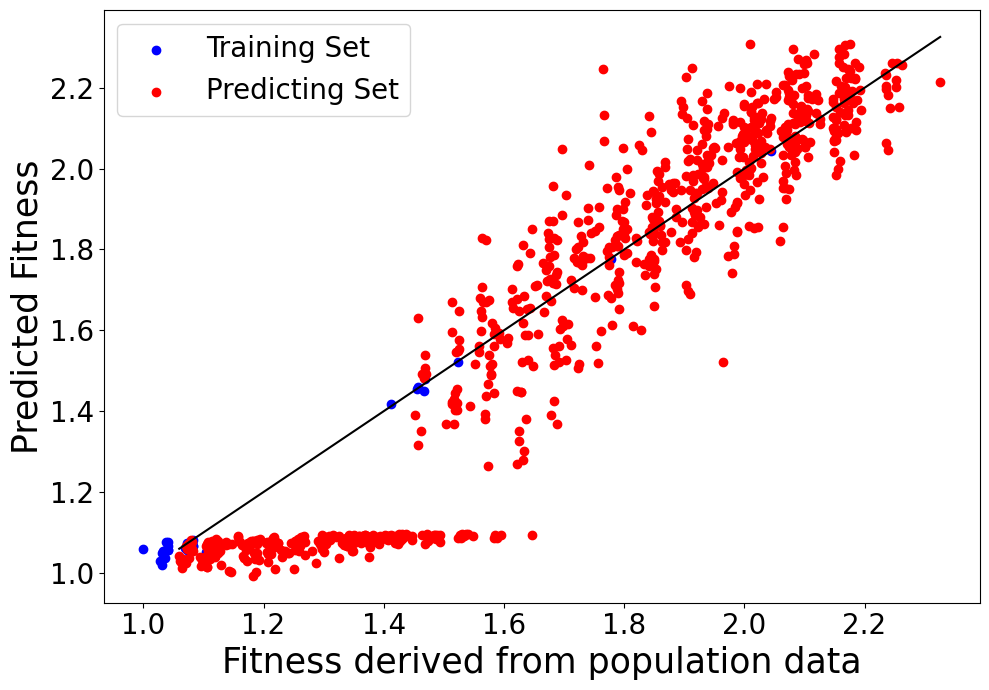

In [22]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Calculate the R^2 score
r2 = r2_score(df_test['real_f'], df_test['pred_f_time'])
print(f'R^2 Score: {r2}')

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 7))  

# Scatter plots for training and test sets
plt.scatter(df_train['real_f'], df_train['pred_f_time'], color='blue', alpha=1, label='Training Set')
plt.scatter(df_test['real_f'], df_test['pred_f_time'], color='red', label='Predicting Set')

# Create the identity line
plt.plot([df_test['real_f'].min(), df_test['real_f'].max()],
         [df_test['real_f'].min(), df_test['real_f'].max()], color='black')

plt.xlabel('Fitness derived from population data', fontsize=25) 
plt.ylabel('Predicted Fitness', fontsize=25)  
plt.legend(fontsize=20)  
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig('../paper/Prediction_of_Relative_Fitness_cutoff.png', dpi=300)
# plt.savefig('Prediction_of_Relative_Fitness_cutoff.eps', format='eps', dpi=1200)
plt.show()


# Understanding of data distribution

In [23]:

def logistic_model(x, a, T, C, K_1, K_2, K_3, K_4):
    return a * (1+C * np.exp(np.log(10)*x[0]/T)) / (C * np.exp(np.log(10)*x[0]/T) + K_1 * np.exp(np.log(10)*x[1]/T) + K_2 * np.exp(np.log(10)*x[2]/T) + K_3 * np.exp(np.log(10)*x[3]/T) + K_4 * np.exp(np.log(10)*x[4]/T) + 1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T 1.59
param [array([1.10274962e+00, 1.59999973e+00, 5.33885286e-06, 3.26054975e-08,
       1.10357282e-09, 3.89374103e-08, 4.54777603e-08])]
reg.coef_ [ 0.04721639 -0.00695687  0.00182792 -0.00834229  0.00842365]
feature ['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']


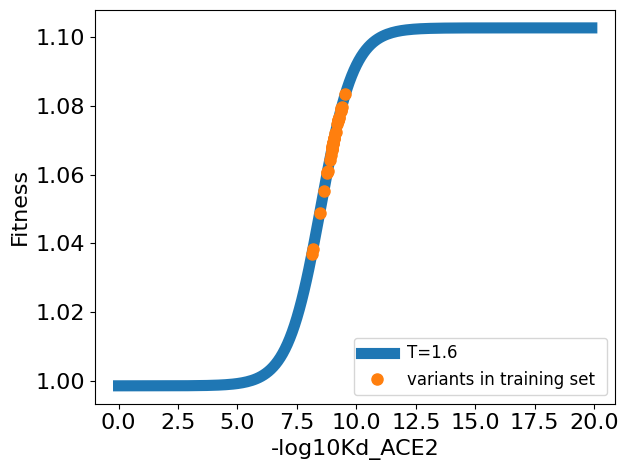

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


feature ['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']


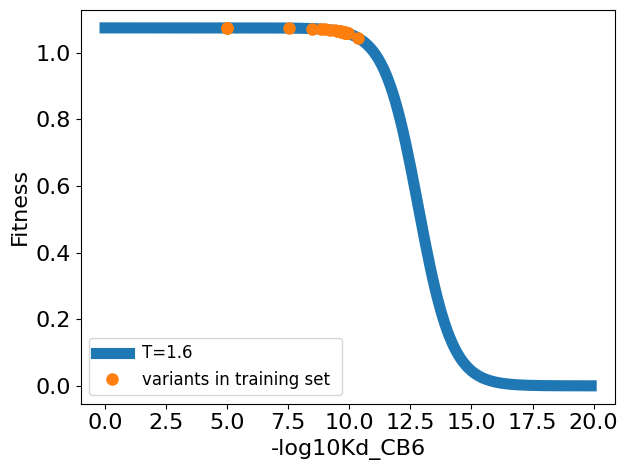

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


feature ['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']


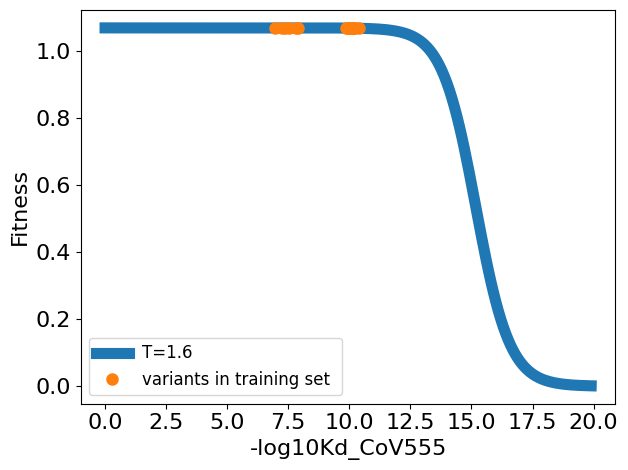

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


feature ['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']


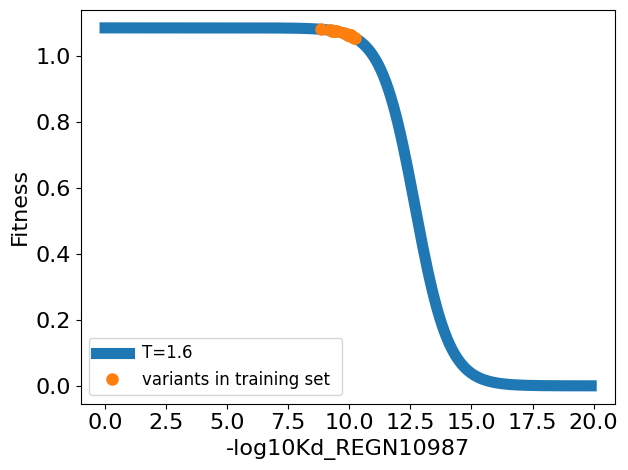

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


feature ['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']


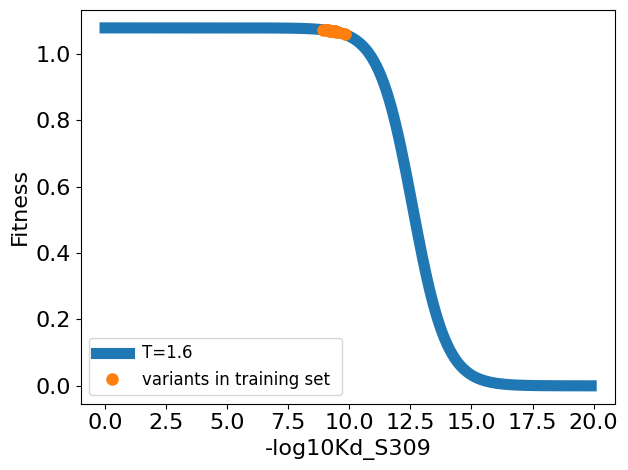

In [24]:
# Set feature matrix
x_data_without = df_train_without[features].values.T

# Initialize an empty list that will store average values of features
AV_LN_FEAT = []

# Iterate over the features and append the mean of each feature to the list
for feature in features:
    AV_LN_FEAT.append(df_train_without[feature].mean())

# Set target vector
y_data_without = df_train_without['real_f'].values

param_matrix = []
for T in [1.59]:
    print('T', T)
    initial_guess = [1, T, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8]
    parameter_bounds = ([0, T-0.01, 0, 0, 0, 0, 0],
                        [np.inf, T+0.01, np.inf, np.inf, np.inf, np.inf, np.inf])
    param, _ = curve_fit(logistic_model, x_data_without, y_data_without, p0=initial_guess, bounds=parameter_bounds, method='trf', maxfev=1000000)
    param_matrix.append(param)
print('param', param_matrix)

# Linear regression
reg = LinearRegression().fit(x_data_without.T, y_data_without)
print('reg.coef_', reg.coef_)

# For each feature, use value of AV_LN_FEAT for the other features and plot the predicted fitness as a function of the feature
for feature in features:
    print('feature', features)

    for t in range(len(param_matrix)):
        param = param_matrix[t]
        y_array = []
        y_reg_array = []

        feat_data = np.arange(0, 20, 0.1)
        for i in range(len(feat_data)):
            x_data = np.array(AV_LN_FEAT)
            x_data[features.index(feature)] = feat_data[i]
            y = logistic_model(x_data, param[0], param[1], param[2], param[3], param[4], param[5], param[6])
            y_array.append(y)
            y_reg = reg.predict(x_data.reshape(1, -1))
            y_reg_array.append(y_reg)

        plt.plot(feat_data, y_array, label='T=' + str(round(param[1], 2)),linewidth=8)

        x_data_exis_array = []
        y_exis_array = []
        for i in range(len(df_train_without[feature])):
            x_data_exis = np.array(AV_LN_FEAT)
            x_data_exis[features.index(feature)] = df_train_without[feature].values[i]
            y_exis = logistic_model(x_data_exis, param[0], param[1], param[2], param[3], param[4], param[5], param[6])
            x_data_exis_array.append(x_data_exis)
            y_exis_array.append(y_exis)

        if t == len(param_matrix) - 1:
            plt.plot(df_train_without[feature], y_exis_array, 'o', label='variants in training set ', alpha=1, markersize=8)
        else:
            plt.plot(df_train_without[feature], y_exis_array, 'o', alpha=1, markersize=5)

    plt.figsize = (10, 8)
    plt.xlabel('-' + feature, fontsize=16)
    plt.ylabel('Fitness', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=12)
    plt.subplots_adjust(bottom=0.2)

    plt.tight_layout()

    # Save
    plt.savefig('../paper/pred_temp_without_T478K_' + feature + '.png', dpi=300) 
    # plt.savefig('pred_temp_without_T478K_' + feature + '.eps', dpi=1200)  

    plt.show()
